In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [205]:
n = 1000
T = 10000
var = 1
x = np.random.normal(0, sigma, (T, n))

In [206]:
C = np.dot(x.T, x) / T

### Eigen values of normally distributed random variables

In [207]:
w, v = np.linalg.eig(C)

In [208]:
w.sort()

### Marcenko-Pastur Probability distribution function

In [214]:
def mpPDF(var, q, pts = 20):
    lambdap = var * np.power(1 + 1./np.sqrt(q), 2)
    lambdan = var * np.power(1 - 1./np.sqrt(q), 2)
    x = np.linspace(lambdan, lambdap, pts)
    y = np.sqrt((lambdap - x) * (x - lambdan)) / (2 * np.pi * x * np.power(sigma,2)) * q
    return pd.Series(y, index = x)

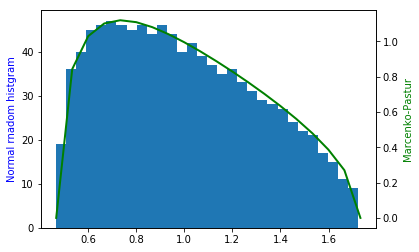

In [215]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist(w, bins=30)
ax2.plot(mpPDF(var, float(T)/ n), 'g-', lw = 2)
ax1.set_ylabel('Normal rnadom histgram', color='b')
ax2.set_ylabel('Marcenko-Pastur', color='g')

plt.show()

In [216]:
from sklearn.neighbors.kde import KernelDensity
# Why not use sklearn.decomposition.PCA?
def getPCA(matrix):
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]
    eVal, eVec = eVal[indices],eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

def fitKDE(obs, bWidth = 0.25, kernel = 'gaussian', x = None):
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel= kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)
    pdf = pd.Series(np.exp(logProb), index = x.flatten())
    return pdf

In [218]:
x = np.random.normal(size=(T,n))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mpPDF(1., float(T)/n,100)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)

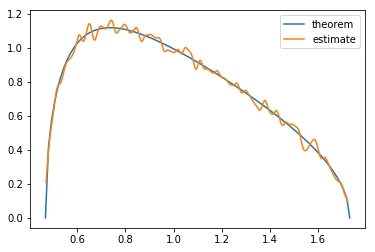

In [219]:
plt.plot(pdf0, label = 'theorem')
plt.plot(pdf1, label = 'estimate')
plt.legend()
plt.show()

In [229]:
def getRndConv(nCols, nFacts):
    w = np.random.normal(size = (nCols, nFacts))
    cov = np.dot(w, w.T)
    cov += np.diag(np.random.uniform(size = nCols))
    return cov

def cov2corr(cov):
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1
    return corr

In [246]:
alpha, nCols, nFact = 0.995, 1000, 100
q = int(nCols / nFact)
cov = np.cov(np.random.normal(size = (nCols * q, nCols)), rowvar=0)
cov = alpha * cov + (1 - alpha) * getRndConv(nCols, nFact)
corr0 = cov2corr(cov)
eVal0, eVec = getPCA(corr0)

In [247]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts = 100):
    pdf0 = mpPDF(var, q, pts)
    pdf1 = fitKDE(eVal, bWidth,x = pdf0.index.values)
    sse = np.sum((pdf1 - pdf0)**2)
    return sse

def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), 
                   0.5, 
                   args=(eVal, q, bWidth),
                   bounds=((1E-5, 1-1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1.0/q)**0.5)**2
    return eMax, var



In [248]:
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

In [249]:
print(nFacts0)

100


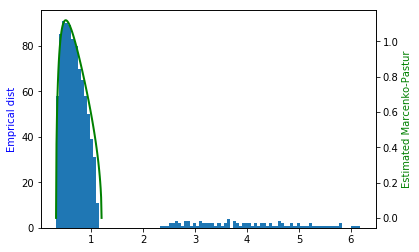

In [263]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist(np.diag(eVal0), bins=100, label = 'Emprical dist')
ax2.plot(mpPDF(var0, q, pts=100), 'g', lw = 2., label = 'Estimated Marcenko-Pastur')
ax1.set_ylabel('Emprical dist', color='b')
ax2.set_ylabel('Estimated Marcenko-Pastur', color='g')
plt.show()